In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import matplotlib.pyplot as plt

import string
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tqdm.pandas()

c:\Users\KamilSarzyniak\anaconda3\envs\AI_DL_ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KamilSarzyniak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", sep=',', decimal='.', encoding='latin-1')
df = df[[df.columns[0], df.columns[-1]]]

In [3]:
df.head()

,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [4]:
df.fillna('', inplace=True)

In [5]:
df[df.columns[-1]] = df[df.columns[-1]].apply(lambda x: re.sub(r'@\S+|http\S+|[^a-zA-Z0-9@\s]', '', x) if isinstance(x, str) else x)

In [6]:
df.head()

,0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,is upset that he cant update his Facebook by t...
1,0,I dived many times for the ball Managed to sa...
2,0,my whole body feels itchy and like its on fire
3,0,no its not behaving at all im mad why am i he...
4,0,not the whole crew


In [7]:
df.columns = ['label', 'text']

In [8]:
df.head()

,label,text
0,0,is upset that he cant update his Facebook by t...
1,0,I dived many times for the ball Managed to sa...
2,0,my whole body feels itchy and like its on fire
3,0,no its not behaving at all im mad why am i he...
4,0,not the whole crew


In [9]:
df["label"] = df["label"].apply(lambda x: 1 if x == 4 else 0)

In [10]:
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

In [11]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [12]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [13]:
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [14]:
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [16]:
df['stemmed_text'] = df['text'].progress_apply(lambda x: stem_text(x))
df['lemmatized_text'] = df['text'].progress_apply(lambda x: lemmatize_text(x))

100%|██████████| 1599999/1599999 [01:32<00:00, 17232.46it/s]


In [67]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['label'], test_size=0.2, random_state=42)

Logistic Regression Model

In [86]:
model = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [87]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [89]:
y_pred_lr = model.predict(X_test)

In [94]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_lr)}')
print(f'Precision:  {precision_score(y_test, y_pred_lr)}')
print(f'Recall: {recall_score(y_test, y_pred_lr)}')
print(f'F1-Score: {f1_score(y_test, y_pred_lr)}')

Accuracy: 0.797790625
Precision:  0.7931587419135693
Recall: 0.807415299116544
F1-Score: 0.8002235278499029


In [95]:
def get_top_keywords(model):
    feature_names = np.array(model.named_steps['tfidf'].get_feature_names_out())
    coef = model.named_steps['clf'].coef_.flatten()
    
    positive_indices = np.argsort(coef)[-10:]
    positive_keywords = feature_names[positive_indices]
    
    toxic_indices = np.argsort(coef)[:10]
    toxic_keywords = feature_names[toxic_indices]
    
    return toxic_keywords, positive_keywords

In [96]:
toxic_keywords, positive_keywords = get_top_keywords(model)

In [97]:
print(toxic_keywords)

['sad' 'miss' 'poor' 'missing' 'sick' 'disappointing' 'gutted' 'suck'
 'broke' 'bummed']


In [98]:
print(positive_keywords)

['welcome' 'thank' 'glad' 'worry' 'wwwiamsoannoyedcom' 'excited' 'thanks'
 'smiling' 'smile' 'wait']


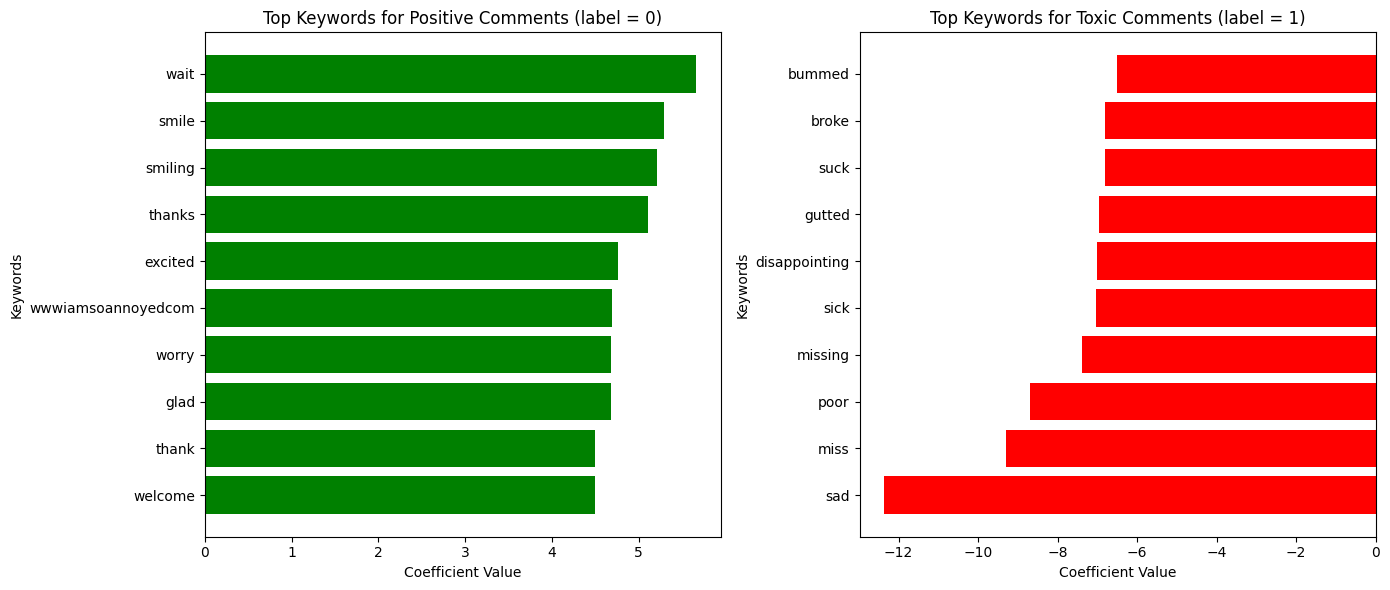

In [99]:
feature_names = np.array(model.named_steps['tfidf'].get_feature_names_out())
coef = model.named_steps['clf'].coef_.flatten()

positive_indices = np.argsort(coef)[-10:]
positive_keywords = feature_names[positive_indices]
positive_coefficients = coef[positive_indices]

toxic_indices = np.argsort(coef)[:10]
toxic_keywords = feature_names[toxic_indices]
toxic_coefficients = coef[toxic_indices]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(positive_keywords, positive_coefficients, color='green')
ax[0].set_title('Top Keywords for Positive Comments (label = 0)')
ax[0].set_xlabel('Coefficient Value')
ax[0].set_ylabel('Keywords')

ax[1].barh(toxic_keywords, toxic_coefficients, color='red')
ax[1].set_title('Top Keywords for Toxic Comments (label = 1)')
ax[1].set_xlabel('Coefficient Value')
ax[1].set_ylabel('Keywords')

plt.tight_layout()
plt.show()



Naive Bayes classifier for multinomial models.

In [100]:
from sklearn.naive_bayes import MultinomialNB

In [107]:
vectorizer = TfidfVectorizer(stop_words="english")
X_tfidf = vectorizer.fit_transform(df['lemmatized_text'])

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)

In [109]:
nb_model = MultinomialNB()

In [110]:
nb_model.fit(X_train, y_train)

MultinomialNB()

In [111]:
y_pred_nb = nb_model.predict(X_test)

In [112]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb)}')
print(f'Precision:  {precision_score(y_test, y_pred_nb)}')
print(f'Recall: {recall_score(y_test, y_pred_nb)}')
print(f'F1-Score: {f1_score(y_test, y_pred_nb)}')

Accuracy: 0.75803125
Precision:  0.767280097805804
Recall: 0.7429192678155334
F1-Score: 0.7549032021170184


In [124]:
def get_top_keywords_nb(model):
    feature_names = np.array(vectorizer.get_feature_names_out())

    toxic_log_probs = model.feature_log_prob_[1]
    positive_log_probs = model.feature_log_prob_[0]

    prob_diff = toxic_log_probs - positive_log_probs

    toxic_indices = np.argsort(prob_diff)[:10]
    positive_indices = np.argsort(prob_diff)[-10:]

    return feature_names[toxic_indices], feature_names[positive_indices]

In [125]:
toxic_keywords, positive_keywords = get_top_keywords_nb(nb_model)

In [126]:
print("🔴 Toxic Keywords:", toxic_keywords)

🔴 Toxic Keywords: ['fawcett' 'isplayer' 'inaperfectworld' 'dontyouhate' 'farrah'
 'pakcricket' 'neda' '447' 'earache' 'triste']


In [127]:
print("🟢 Positive Keywords:", positive_keywords)

🟢 Positive Keywords: ['atcha' 'wwwm2easia' 'dividend' 'fuzzball' 'emailunlimited' 'timefollow'
 'laughhave' 'wwwiamsoannoyedcom' 'wwwtweeterfollowcom'
 'wwwtweeteraddercom']


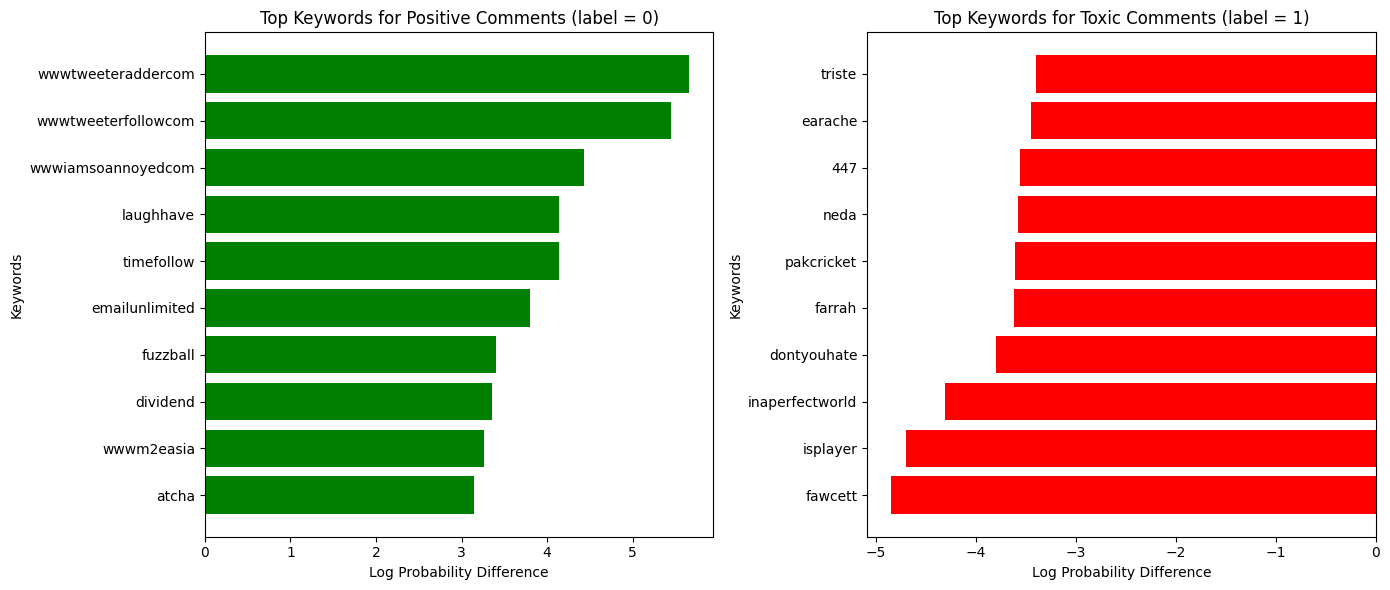

In [132]:
feature_names = np.array(vectorizer.get_feature_names_out())

toxic_log_probs = nb_model.feature_log_prob_[1]
positive_log_probs = nb_model.feature_log_prob_[0]

prob_diff = toxic_log_probs - positive_log_probs

toxic_indices = np.argsort(prob_diff)[:10]
positive_indices = np.argsort(prob_diff)[-10:]

toxic_keywords = feature_names[toxic_indices]
toxic_coefficients = prob_diff[toxic_indices]

positive_keywords = feature_names[positive_indices]
positive_coefficients = prob_diff[positive_indices]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].barh(positive_keywords, positive_coefficients, color='green')
ax[0].set_title('Top Keywords for Positive Comments (label = 0)')
ax[0].set_xlabel('Log Probability Difference')
ax[0].set_ylabel('Keywords')

ax[1].barh(toxic_keywords, toxic_coefficients, color='red')
ax[1].set_title('Top Keywords for Toxic Comments (label = 1)')
ax[1].set_xlabel('Log Probability Difference')
ax[1].set_ylabel('Keywords')

plt.tight_layout()
plt.show()

W analizie zostały wykorzystane 2 modele, Regresja Logistyczna oraz Naiwny klasyfikator Bayesa dla modeli wielomianowych. Jeżeli bierzemy pod uwagę accuracy, precision, recal oraz F1-score to tutaj niewiele, chociaż jednak zauważalnie lepszy jest model Regresji Logistycznej. Jest lepszy średnio o 5 p.p. dla każdej miary. Można to tłumaczyć tym, iż model Bayesa opisuje liczbę wystąpień poszczególnych słów w dokumencie. Oznacza to, że nie bierze pod uwagę interakcji między słowami, co w badanym przypadku może prowadzić do nieoptymalych wyników. Regresja Logistyczna z kolei umożliwia uwzględnienie zależności między słowami. RL modeluje prawdopodobieństwo przynależności do jednej z klas na podstawie wag przypisanych słowom, gdzie NB opiera się na założeniu, że wszystkie słowa są niezależne. RL jest bardziej odporna na często występujące słowa (np. stop words) i rzadkie cechy, ponieważ polega na prostych estymacjach częstotliwości słów, a NB ma z tym jednak problem.

W końcu NB jest bardzo efektywny obliczeniowo, szczególnie dla dużych zbiorów danych, ponieważ ma proste obliczenia i szybko się trenuje. Jednak ta efektywność odbywa się kosztem elastyczności w modelowaniu bardziej złożonych zależności. RL z kolei dzieki możliwości modelowania bardziej skomplikowanych wzorców, zazwyczaj osiąga lepszą dokładność w trudnych zadaniach klasyfikacyjnych.

Warto też zauważyć, iż nawet same słowa jakie wykrywa RL są o wiele bardziej realistyczne i odzwierciedlają prawdziwe wyniki w przeciwieństwie NB, gdzie wyniki są o wiele gorsze.